In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import random
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') # so we can do .to(device)
else:
    device = torch.device('cpu')

# Value Iteration

Value iteration is a method to solve for the optimal policy in Markov Decision Process by iteratively updating the value of each state. The algorithm for value iteration is shown below:

<figure>
  <div style="text-align:center;">
  <img src="assets/05/value_iteration_algo.png", width = 450>
  <figcaption>Source: Richard S. Sutton and Andrew G. Barto. Reinforcement Learning: An Introduction.</figcaption>
  </div>
</figure>

In this example, we will use the cartpole environment from OpenAI gym. The states of this environment are cartpole position $x$, cartpole velocity $\dot{x}$, pole angle $\theta$, and pole angular velocity $\dot{\theta}$. 

<figure>
  <div style="text-align:center;">
  <img src="assets/05/cartpole.png", width = 300>
  </div>
</figure>

The episode is done when:
- $x$ < -env.x_threshold or $x$ > env.x_threshold
- $\theta$ < -env.theta_threshold_radians or $\theta$ > env.theta_threshold_radians

The reward is 0 when the episode is done, otherwise the rewards is +1. In other words, we want the agent to keep the cartpole and pole within the range of desired states as long as possible.

We're not actually going to run this until it converges because it will take too much time. However, it is still interesting to see how one can implement value iteration to solve this environment so we can understand and appreciate the challenges.

In [3]:
env = gym.make('CartPole-v1')

In [4]:
class ModifiedCartpoleEnv(gym.envs.classic_control.CartPoleEnv):
    def __init__(self, render_mode):
        super().__init__(render_mode)
    def reset(self, state=None):
        """
        Modify reset function so we can teleport to any particular states if we want to.
        """
        if state is not None:
            self.state = state
        else:
            self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

In [5]:
env = ModifiedCartpoleEnv(render_mode="rgb_array")
state = env.reset()

Value iteration requires us to compute the value of all $s \in S$. Practically, we need to discretize the state and action space to do this.

In [6]:
# Define number of possible states and range for each states
n_x, x_min, x_max = 5, -env.x_threshold, env.x_threshold
n_x_dot, x_dot_min, x_dot_max = 5, -8.0, 8.0 # actually from -inf to +inf
n_theta, theta_min, theta_max = 5, -env.theta_threshold_radians, env.theta_threshold_radians
n_theta_dot, theta_dot_min, theta_dot_max = 5, -10.0, 10.0 # actually from -inf to +inf 

In [7]:
# States
x_range = np.linspace(x_min, x_max, num = n_x)
x_dot_range = np.linspace(x_dot_min, x_dot_max, num = n_x_dot)
theta_range = np.linspace(theta_min, theta_max, num = n_theta)
theta_dot_range = np.linspace(theta_dot_min, theta_dot_max, num = n_theta_dot)

# Actions
u_range = (0,1)

# Create meshgrid
x_v, x_dot_v, theta_v, theta_dot_v = np.meshgrid(x_range, x_dot_range, theta_range, theta_dot_range)

In [8]:
# Create list of list with all possible states
states = []
for i in range(n_x):
    for j in range(n_x_dot):
        for k in range(n_theta_dot):
            for l in range(n_theta):
                s = np.array([x_v[i,j,k,l], x_dot_v[i,j,k,l], theta_v[i,j,k,l], theta_dot_v[i,j,k,l]])
                states.append(s)

In [9]:
def discretize_state(state):
    """
    Function to discretize state into the range we specified above.
    NOTE: (x_range, x_dot_range, theta_range, theta_dot_range) are defined globally in this notebook.
    """
    
    x = state[0]
    x_dot = state[1]
    theta = state[2]
    theta_dot = state[3]
    discretized_x = x_range[np.argmin(abs(x - x_range))] 
    discretized_x_dot = x_dot_range[np.argmin(abs(x_dot - x_dot_range))]
    discretized_theta = theta_range[np.argmin(abs(theta - theta_range))]
    discretized_theta_dot = theta_dot_range[np.argmin(abs(theta_dot - theta_dot_range))]
    discretized_state = np.array([discretized_x, 
                                  discretized_x_dot, 
                                  discretized_theta, 
                                  discretized_theta_dot])
    return discretized_state

def get_state_index(states, discretized_state):
    """
    Function to map the discretized_state onto its corresponding index in states.
    """
    
    diff = states - discretized_state
    flags = np.any(diff, axis=1)
    idx = np.where(flags==False)[0][0]
    return idx

In [10]:
convergence_threshold = 0.9
delta = 100000
gamma = 0.99
deltas = []
V = np.zeros(n_x * n_x_dot * n_theta * n_theta_dot) # initialize V(s) = 0 for all states

num_iter = 0
while delta > convergence_threshold:
    delta = 0
    for i in range(len(states)): # for each possible state
        state = states[i]
        v = V[i] # value of current state
        V_max = -999999999
        for u in u_range: # evaluate all possible actions (due to V(s) <- max_a ...)
            env.reset(state = state) # make sure we are at state = state
            next_state, r, terminated, truncated, _  = env.step(u) # apply u for one step
            discretized_next_state = discretize_state(next_state)
            next_state_index = get_state_index(states, discretized_next_state)
            value = r + gamma * V[next_state_index]
            if value > V_max:
                V_max = value
        V[i] = V_max # update value of current state
        delta = max(delta, abs(v - V_max)) # update delta for convergence check
    deltas.append(delta)
    num_iter+=1
    if num_iter % 10 == 0:
        print('num_iter: ', num_iter, ' --- delta: ', delta)
print('Value iteration converged after %d iterations' % num_iter)

/usr/local/lib/python3.8/dist-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


num_iter:  10  --- delta:  0.9135172474836413
Value iteration converged after 12 iterations


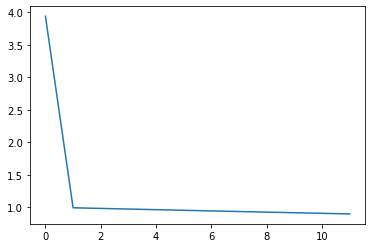

In [11]:
plt.plot(deltas)
plt.show()

Next, we need to determine how we choose an action based on $V(s)$. For example, we can do this greedily by doing:

$$
\pi(s) = \arg\max_a \sum_{s',r} p(s',r|s,a)[r + \gamma V(s')] 
$$

So, let's create another lookup table for the policy.

In [12]:
def get_best_policy(V):
    """
    Function to return the optimal policy from a given V.
    NOTE: (states, n_x, n_x_dot, n_theta_dot, n_theta, gamma) are defined globally in this notebook.
    """
    policy = np.zeros(n_x * n_x_dot * n_theta_dot * n_theta)
    for i in range(len(V)):
        state = states[i]
        V_max = -999999999
        u_max = -999999999
        for u in u_range: # evaluate all action
            env.reset(state = state) # make sure we are at state = state
            next_state, r, terminated, truncated, _  = env.step(u) # apply u for one step
            discretized_next_state = discretize_state(next_state)
            next_state_index = get_state_index(states, discretized_next_state)
            value = r + gamma * V[next_state_index]
            if value > V_max:
                V_max = value
                u_max = u
        policy[i] = u_max
    return policy

In [13]:
policy = get_best_policy(V)

Now, let's see the performance of the agent.

In [14]:
def get_action(state, policy):
    """
    Function to get what action to take according to the policy.
    NOTE: (states) is defined globally in this notebook.
    """
    discretized_state = discretize_state(state)
    state_index = get_state_index(states, discretized_state)
    u = policy[state_index]
    return u

In [ ]:
state = env.reset()
terminated = False
truncated = False
total_reward = 0
while not (terminated or truncated):
    action = get_action(state, policy)
    state, reward, terminated, truncated,  _ = env.step(int(action))
    total_reward += reward
    env.render()
    if terminated or truncated:
        break
print(total_reward)

From this example, we can identify several challenges:
1. If discretization is not fine enough, then applying an action may not change the state at all.
2. If discretization is too fine, then it will take a long time for the algorithm to converge.
3. As the state and action spaces get bigger, the computation needed to do value iteration increases drastically.

Now, let's take a look at REINFORCE.

# REINFORCE

REINFORCE is an on-policy (i.e., the model is trained exclusively on data generated using the current policy) policy gradient algorithm. Let our policy $\pi$ to be parametrized by $\theta$ (e.g., parameters of a neural network). Our goal is to find the parameter $\theta$ that maximizes the expected return of trajectory $G(\tau)$, where $\tau$ denotes a trajectory obtained from following policy $\pi_{\theta}$. So the objective can be written as:

$$
J (\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}} [G(\tau)]
$$

The policy gradient is then (we will skip the derivation of the policy gradient for now, but I highly encourage you to look at it):

$$
\nabla_{\theta} J (\theta) = \mathbb{E}_{\tau \sim \pi_{\theta}} [\sum_{t=0}^{T} G_{t}(\tau) \nabla_{\theta} \log \pi_{\theta}(a_t|s_t)]
$$

Once we know $\nabla_{\theta} J (\theta)$, we can update $\theta$ with gradient ascent. In practice, we approximate the policy gradient via Monte-Carlo sampling by just considering a **single** trajectory, which gives us:

$$
\nabla_{\theta} J (\theta) \approx \sum_{t=0}^{T} G_{t}(\tau) \nabla_{\theta} \log \pi_{\theta}(a_t|s_t)
$$

The REINFORCE algorithm is shown below:

<figure>
  <div style="text-align:center;">
  <img src="assets/05/reinforce_algo.png", width = 750>
  <figcaption>Source: Richard S. Sutton and Andrew G. Barto. Reinforcement Learning: An Introduction.</figcaption>
  </div>
</figure>

For each iteration, we collect an episode trajectory following the current policy. At the end of each episode, we use this trajectory to get the return $G$ and log probability of action at each time step within the episode, which allows us to compute the policy gradient and update the parameters of the policy. After we update our network, we forget about the trajectory we just collected and collect a new one with the latest policy, and the processes are repeated.

Let's take a look at the implementation. The code below is adapted from REINFORCE implementation example from PyTorch repo (source: https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py).

In [ ]:
# Initialize the environment
env = gym.make('CartPole-v1')

In [ ]:
# Create the policy network
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, action_dim)
        self.saved_log_probs = []
        self.rewards = []
        
    def forward(self, inp):
        x = self.fc1(inp)
        x = self.dropout(x)
        x = F.relu(x)
        logits = self.fc2(x)
        out = F.softmax(logits, dim = 1)
        return out

In [ ]:
class REINFORCEAgent(object):
    def __init__(self, state_dim, action_dim):
        super(REINFORCEAgent, self).__init__()
        self.policy = PolicyNet(state_dim, action_dim).to(device)
        self.policy.train()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-2)
        self.gamma = 0.99
        self.log_interval = 10 # print progress per this many episodes
    
    def clean_memory(self):
        del self.policy.rewards[:]
        del self.policy.saved_log_probs[:]
    
    def select_action(self, input_state):
        state = torch.from_numpy(input_state).float().unsqueeze(0)
        action_probs = self.policy(state.to(device))
        m = Categorical(action_probs)
        action = m.sample()
        self.policy.saved_log_probs.append(m.log_prob(action))
        return action.item()

    def update(self):
        G = 0
        policy_loss = []
        returns = []
        for r in self.policy.rewards[::-1]:
            G = r + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-7) # normalized returns
        for log_prob, G in zip(self.policy.saved_log_probs, returns):
            policy_loss.append(-log_prob * G)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum() # a scalar
        policy_loss.backward()
        self.optimizer.step()
        self.clean_memory() # empty self.rewards and self.saved_log_probs (on-policy!)

Let's start training the agent.

In [ ]:
state_dim = 4 # (x, x_dot, theta, theta_dot)
action_dim = 2 # (0, 1)
agent = REINFORCEAgent(state_dim, action_dim)

In [ ]:
running_reward = 10
ep_rewards = [] # to store episode reward so we can plot it later
for i in range(1, 10000):
    state, ep_reward = env.reset(), 0
    for _ in range(1, 10000):
        action = agent.select_action(state)
        state, reward, done, _ = env.step(action)
        agent.policy.rewards.append(reward)
        ep_reward += reward
        env.render()
        if done:
            break
    ep_rewards.append(ep_reward)
    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    agent.update()
    
    if i % agent.log_interval == 0:
        print('Episode %d \t Running Reward: %.2f \t Last Episode Reward: %d' % (i, running_reward, ep_reward))
    
    # Stopping criteria
    if running_reward > 100:
        print('Solved: Episode %d \t Running Reward: %.2f \t Last Episode Reward: %d' 
              % (i, running_reward, ep_reward))
        break

In [ ]:
plt.plot(ep_rewards)
plt.xlabel('episode #')
plt.ylabel('episode rewards')
plt.grid()
plt.show()

In [ ]:
env.close()

# Deep Q Networks (DQN)

DQN is an off-policy Q learning method. Unlike REINFORCE, DQN learns a Q networks (as opposed to policy) and can use trajectories that the agent has collected in the past to train the current Q network by storing them in a replay buffer. The learning objective in DQN is also different than in REINFORCE: DQN tries to minimize the **Temporal Difference (TD)** error (i.e., difference between prediction of Q values and the TD target). We are not going to talk about TD learning in detail here, but if you are especially interested to work with RL, I recommend you to look into TD learning and SARSA to have a better understanding about DQN. The TD target for DQN is defined as:

$$
Q_{target}(s,a) = r + \gamma \max_{a'}Q(s',a')
$$

The DQN algorithm is shown below:

<figure>
  <div style="text-align:center;">
  <img src="assets/05/dqn_algo.png", width = 600>
  <figcaption>Source: Mnih et al. (2013). Playing Atari with Deep Reinforcement Learning.</figcaption>
  </div>
</figure>

Note that depending on the use case, we may or may not use the feature network $\phi$ shown in the algorithm above. For this example, we know what the state is, so we do not need to differentiate between observations $x$ and states $s$.

In practice, we often use another network that is a lagged copy of the Q-network to generate the TD target in order to stabilize training. We call this a **target network**. If you are interested to know more about this, I encourage you to read the paper :)

Generally, with off-policy methods, one needs to be aware of memory usage since we are storing a lot of information in the replay buffer. This can be problematic especially when the state dimension is high (e.g., images).

Let's now take a look at the implementation.

In [ ]:
env = gym.make('CartPole-v1')

In [ ]:
class ReplayBuffer():
    def __init__(self, buffer_size):
        # Use deque instead of list so we do not have to manually 
        # pop the buffer when it reaches max buffer size
        self.buffer = deque(maxlen = buffer_size) 
    
    def update(self, state, action, reward, next_state, done):
        """
        Function to push the data into buffer.
        Input:
            - state: state ndarray [state_dim (e.g., H x W x 3)]
            - action: int
            - reward: float
            - next_state: next_state ndarray [state_dim (e.g., H x W x 3)]
            - done: bool
        """
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self, batch_size):
        """
        Function to sample a batch from replay buffer.
        Input:
            - batch_size: an int
        """
        samples = random.sample(self.buffer, batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for i in range(batch_size):
            state = samples[i][0]
            action = samples[i][1]
            reward = samples[i][2]
            next_state = samples[i][3]
            done = samples[i][4]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return np.stack(states), np.stack(actions), np.stack(rewards), np.stack(next_states), np.stack(dones)

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, inp):
        x = F.relu(self.dropout(self.fc1(inp)))
        out = self.fc2(x)
        return out

In [ ]:
class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        super(DQNAgent, self).__init__()
        
        # DQN parameters
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.buffer_size = 1000
        self.epsilon_init = 1.0
        self.epsilon_end = 0.05
        self.epsilon_decay = 200
        self.gamma = 0.99
        self.log_interval = 250 # print progress per this many episodes
        self.target_update_freq = 10 # update target network per this many episodes
        
        # Models
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict()) # copy of q_network
        self.replay_buffer = ReplayBuffer(self.buffer_size)
        
        # Optimizers
        self.q_network_optimizer = optim.Adam(self.q_network.parameters(), lr = 1e-2)
        self.q_network.train()
        self.target_network.eval() # We never train the network we use to generate the TD target!


    def get_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # [1, dim_space]
        # Using epsilon greedy as our policy
        if np.random.random() > epsilon:
            with torch.no_grad():
                q_value = self.q_network(state) # [1, action_space]
                action  = q_value.max(1) # returns both the max values and max index
                action = action[1].data[0] # [1] indicates we want the max index
                action = action.item()
        else: # With probability epsilon, select random action
            action = random.randrange(self.action_dim)
        return action

    
    def update(self, batch_size):
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        # Convert ndarray to torch tensor
        states = torch.from_numpy(states).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        dones = torch.from_numpy(dones).float().to(device)
        
        # Calculate TD error
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1) # [batch_size]
        next_q_values = self.target_network(next_states).max(1)[0].detach() # [0] indicates we want the max values (not the indices!), detach since this is the target # [batch_size]
        td_target = rewards + self.gamma * next_q_values * (1. - dones) 
        loss = F.mse_loss(q_values, td_target)
        
        # Update model
        self.q_network_optimizer.zero_grad()
        loss.backward()
        self.q_network_optimizer.step()

Let's start training the agent.

In [ ]:
state_dim = 4
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

In [ ]:
batch_size = 32
running_reward = 10
target_update_freq = 10 # update target network every X episode
episode = 1 # indicate episode number

state, ep_reward = env.reset(), 0
for i in range(1, 10000):
    
    # Update epsilon and pick action
    epsilon = agent.epsilon_end + (agent.epsilon_init - agent.epsilon_end) * np.exp(-1. * i / agent.epsilon_decay)
    action = agent.get_action(state, epsilon)

    # Take a step
    next_state, reward, done, _ = env.step(action)
    env.render()

    # Update replay buffer
    agent.replay_buffer.update(state, action, reward, next_state, done)

    # Once replay buffer size is larger than batch size, start training
    if len(agent.replay_buffer.buffer) > batch_size:
        agent.update(batch_size)

    # Update episode reward and check for end episode
    ep_reward += reward
    if done: # If episode is done: update running reward, reset env, reset episode reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        episode += 1 # increment episode count (used for updating target network)
        state, ep_reward = env.reset(), 0
    else:
        state = next_state

    # Occasionally, update the target_network by copying the q_network
    if episode % agent.target_update_freq == 0:
        agent.target_network.load_state_dict(agent.q_network.state_dict())
        
    if i % agent.log_interval == 0:
        print('Episode %d \t Running Reward: %.2f' 
              % (i, running_reward))
    
    # Stopping criteria
    if running_reward > 100:
        print('Solved: Episode %d \t Running Reward: %.2f' 
              % (i, running_reward))
        break

In [ ]:
env.close()